In [1]:
# First lets improve libraries that we are going to be used in this lab session
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import spacy
import string
import csv
import io
import argparse
random.seed(134)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 128
MAX_WORD_LENGTH = 78

#parser = argparse.ArgumentParser(description='PyTorch CNN text classifier.')
#parser.add_argument('--hidden_dim', type=int, default=200, metavar='N',
#                    help='the hidden dimension of the encoder (default: 200)')
#parser.add_argument('--epochs', type=int, default=7, metavar='N',
#                    help='number of epochs to train (default: 7)')
#parser.add_argument('--lr', type=float, default=3e-4, metavar='LR',
#                       help='learning rate (default: 3e-4)')
#parser.add_argument('--droprate', type=float, default=0.4, metavar='dr',
#                       help='learning rate (default: 0.4)')
#args = parser.parse_args()
#print("training epochs: {}, learning rate: {}, hidden dimension: {}, dropout rate: {}".
#      format(args.epochs, args.lr, args.hidden_dim, args.droprate))

In [2]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        #data[tokens[0]] = map(float, tokens[1:])
        data[tokens[0]] = tokens[1:]
    return data

# entailment=0, contradict=1, neural=2
def read_snli_tsv(path):
    readin_data = [] 
    with open(path) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for row in reader:
            if row[2] == 'label':
                continue
            if row[2] == 'entailment':
                readin_data.append((row[0],row[1], 0))
            elif row[2] == 'contradiction':
                readin_data.append((row[0],row[1], 1))
            else:
                readin_data.append((row[0],row[1], 2))
    return readin_data
data_vector = load_vectors('wiki-news-300d-1M.vec')

In [3]:
def build_vocab(data):
    # Returns:
    # id2char: list of chars, where id2char[i] returns char that corresponds to char i
    # char2id: dictionary where keys represent chars and corresponding values represent indices
    # some preprocessing
    max_len1 = max([len(word[0]) for word in data])
    max_len2 = max([len(word[1]) for word in data])
    max_len = max(max_len1, max_len2)
    all_chars = []
    for word in data:
        all_chars += word[0]
        all_chars += word[1]
    unique_chars = list(set(all_chars))

    id2char = unique_chars
    char2id = dict(zip(unique_chars, range(2,2+len(unique_chars))))
    id2char = ['<pad>', '<unk>'] + id2char
    char2id['<pad>'] = PAD_IDX
    char2id['<unk>'] = UNK_IDX

    return char2id, id2char, max_len

def covert_to_token(data):
    return [(tokenize(sample[0]), tokenize(sample[1]), sample[2]) for sample in data]

def tokenize(sent):
   tokens = tokenizer(sent)
   return [token.lemma_.lower() for token in tokens if (token.lemma_ not in punctuations)]

### Function that preprocessed dataset
def read_data():
    train_data = read_snli_tsv('./hw2_data/snli_train.tsv')
    val_data = read_snli_tsv('./hw2_data/snli_val.tsv')
    train_data, val_data = covert_to_token(train_data), covert_to_token(val_data)
    char2id, id2char, max_len = build_vocab(train_data)
    return train_data, val_data, char2id, id2char, max_len


In [4]:
#train_data, val_data, char2id, id2char, MAX_WORD_LENGTH = read_data()
#print ("Maximum word length of dataset is {}".format(MAX_WORD_LENGTH))
#print ("Number of characters in dataset is {}".format(len(id2char)))
#print ("Characters:")
#print (char2id.keys())
#print (len(char2id.keys()))

In [5]:
import pickle
#pickle.dump((train_data, val_data, char2id, id2char), open("snli_data_save.p", "wb"))
train_data, val_data, _, _ = pickle.load(open("snli_data_save.p", "rb"))
sub_train_data = train_data[::20]

In [6]:
all_chars = []
for key in data_vector:
    all_chars.append(key)
unique_chars = list(set(all_chars))  
id2char = unique_chars
char2id = dict(zip(unique_chars, range(2,2+len(unique_chars))))
id2char = ['<pad>', '<unk>'] + id2char
char2id['<pad>'] = PAD_IDX
char2id['<unk>'] = UNK_IDX

In [7]:
def process_data(in_data):
    for i in range(len(in_data)):
        for ii in range(len(in_data[i][0])):
            if in_data[i][0][ii] not in data_vector:
                in_data[i][0][ii] = '<unk>'
        for ii in range(len(in_data[i][1])):
            if in_data[i][1][ii] not in data_vector:
                in_data[i][1][ii] = '<unk>'
    return in_data

train_data = process_data(train_data)
val_data = process_data(val_data)
sub_train_data = process_data(sub_train_data)

In [8]:
embedding_matrix = torch.zeros(len(id2char), 300, dtype=torch.float)
for i in range(len(id2char)):
    if id2char[i] == '<unk>' or id2char[i] == '<pad>':
        continue
    embedding_matrix[i,:] = torch.from_numpy(np.reshape(np.array(data_vector[id2char[i]],dtype=np.float32),(1,300)))

### Now lets build the PyTorch DataLoader as we did in previous lab

In [9]:
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, char2id):
        """
        @param data_list: list of character
        @param target_list: list of targets
        """
        self.data_list1, self.data_list2, self.target_list = zip(*data_tuple)
        assert (len(self.data_list1) == len(self.target_list))
        self.char2id = char2id

    def __len__(self):
        return len(self.data_list1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        char_idx1 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.data_list1[key][:MAX_WORD_LENGTH]]
        char_idx2 = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.data_list2[key][:MAX_WORD_LENGTH]]
        char_idx = (char_idx1, char_idx2)
        len_char = (len(char_idx1), len(char_idx2))
        label = self.target_list[key]
        return [char_idx, len_char, label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    for datum in batch:
        label_list.append(datum[2])
        if datum[1][0] > MAX_WORD_LENGTH:
            length_list1.append(MAX_WORD_LENGTH)
        else:
            length_list1.append(datum[1][0])
        if datum[1][1] > MAX_WORD_LENGTH:
            length_list2.append(MAX_WORD_LENGTH)
        else:
            length_list2.append(datum[1][1])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0][0]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[1][0])),
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[0][1]),
                                pad_width=((0,MAX_WORD_LENGTH-datum[1][1])),
                                mode="constant", constant_values=0)
        
        data_list1.append(padded_vec1)
        data_list2.append(padded_vec2)
        
    ind_dec_order1 = np.argsort(length_list1)[::-1]
    ind_back_order1 = np.zeros_like(ind_dec_order1)
    for i in range(len(ind_dec_order1)):
        ind_back_order1[ind_dec_order1[i]] = i
    ind_dec_order2 = np.argsort(length_list2)[::-1]
    ind_back_order2 = np.zeros_like(ind_dec_order2)
    for i in range(len(ind_dec_order2)):
        ind_back_order2[ind_dec_order2[i]] = i
    
    
    data_list1 = np.array(data_list1)[ind_dec_order1]
    data_list2 = np.array(data_list2)[ind_dec_order2]
    
    length_list1 = np.array(length_list1)[ind_dec_order1]
    length_list2 = np.array(length_list2)[ind_dec_order2]
    
    #label_list1 = np.array(label_list1)[ind_dec_order1]
    #label_list2 = np.array(label_list2)[ind_dec_order2]
    
    out_data = [torch.from_numpy(np.array(data_list1)), torch.from_numpy(np.array(data_list2))]
    out_length = [torch.LongTensor(np.array(length_list1)), torch.LongTensor(np.array(length_list2))]
    ind_back = (ind_back_order1, ind_back_order2)
    label_list = torch.LongTensor(np.array(label_list))
    return (out_data, out_length, label_list, ind_back)


In [10]:
# Build train, valid and test dataloaders

train_dataset = VocabDataset(train_data, char2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_data, char2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

sub_train_dataset = VocabDataset(sub_train_data, char2id)
sub_train_loader = torch.utils.data.DataLoader(dataset=sub_train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

### Now lets implement basic Recurrent Neural Net model

In [11]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers, self.hidden_size = num_layers, hidden_size
        #self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.lstm = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.dropout1 = nn.Dropout(0.0)
        self.linear1 = nn.Linear(hidden_size*4, hidden_size*4)
        #self.dropout2 = nn.Dropout(0.0)
        self.linear2 = nn.Linear(hidden_size*4, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.zeros(self.num_layers*2, batch_size, self.hidden_size) #rnn
        #hidden = (torch.zeros(self.num_layers*2, batch_size, self.hidden_size),torch.zeros(self.num_layers*2, batch_size, self.hidden_size)) #lstm
        return hidden

    def forward(self, x, lengths, ind_backs):
        # reset hidden state  
        
        batch_size, seq_len = x[0].size()
        
        
        self.hidden = self.init_hidden(batch_size)
        # get embedding of characters
        embed1 = embedding_matrix[x[0],:]
        embed2 = embedding_matrix[x[1],:]
        # pack padded sequence
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths[0].numpy(), batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, lengths[1].numpy(), batch_first=True)
        # fprop though RNN
        rnn_out1, self.hidden_out = self.lstm(embed1, self.hidden)
        rnn_out2, self.hidden_out = self.lstm(embed2, self.hidden)
        # undo packing
        rnn_out1, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out1, batch_first=True)
        rnn_out2, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out2, batch_first=True)
        # sum hidden activations of RNN across time
        #rnn_out = torch.sum(rnn_out, dim=1)
        #rnn_out = torch.max(rnn_out, dim=1)
        rnn_out_f1 = rnn_out1[:, -1, :self.hidden_size]
        rnn_out_b1 = rnn_out1[:, 0, self.hidden_size:]
        rnn_out_f2 = rnn_out2[:, -1, :self.hidden_size]
        rnn_out_b2 = rnn_out2[:, 0, self.hidden_size:]
        rnn_concat = torch.cat((rnn_out_f1[ind_backs[0],...], rnn_out_b1[ind_backs[0],...], rnn_out_f2[ind_backs[1],...], rnn_out_b2[[ind_backs[1],...]]), 1)
        mid_fea = F.relu(self.linear1(rnn_concat))
        logits = self.linear2(mid_fea)
        return logits


In [13]:
model = RNN(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, vocab_size=len(id2char))
model.load_state_dict(torch.load('./model/gru_text_e7_h200.pth'))

In [29]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels, ind_backs in loader:
        data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, lengths_batch, ind_backs), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)


model = RNN(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, vocab_size=len(id2char))
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)

learning_rate = 5e-4

test_num = 0
val_acc = []
train_acc = []
num_epochs = 7
# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (data, lengths, labels, ind_backs) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data, lengths, ind_backs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc.append(test_model(val_loader, model))
            train_acc.append(test_model(sub_train_loader, model))
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Train Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc[test_num], train_acc[test_num]))
            test_num += 1
#pickle.dump((val_acc, train_acc), open("./model/snli_gru_acc_e{}_h{}.p".format(args.epochs,
#                                                                    args.hidden_dim), "wb"))
print('training acc: ',test_model(train_loader, model))

Epoch: [1/7], Step: [301/782], Validation Acc: 55.5, Train Acc: 60.02
Epoch: [1/7], Step: [301/782], Validation Acc: 55.5, Train Acc: 60.02
Epoch: [1/7], Step: [601/782], Validation Acc: 60.2, Train Acc: 62.36
Epoch: [1/7], Step: [601/782], Validation Acc: 60.2, Train Acc: 62.36
Epoch: [2/7], Step: [301/782], Validation Acc: 63.6, Train Acc: 64.5
Epoch: [2/7], Step: [301/782], Validation Acc: 63.6, Train Acc: 64.5
Epoch: [2/7], Step: [601/782], Validation Acc: 65.3, Train Acc: 66.66
Epoch: [2/7], Step: [601/782], Validation Acc: 65.3, Train Acc: 66.66
Epoch: [3/7], Step: [301/782], Validation Acc: 66.6, Train Acc: 68.28
Epoch: [3/7], Step: [301/782], Validation Acc: 66.6, Train Acc: 68.28
Epoch: [3/7], Step: [601/782], Validation Acc: 68.7, Train Acc: 69.32
Epoch: [3/7], Step: [601/782], Validation Acc: 68.7, Train Acc: 69.32
Epoch: [4/7], Step: [301/782], Validation Acc: 68.8, Train Acc: 70.42
Epoch: [4/7], Step: [301/782], Validation Acc: 68.8, Train Acc: 70.42
Epoch: [4/7], Step: [6

In [30]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels, ind_backs in loader:
        data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, lengths_batch, ind_backs), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

test_model(val_loader, model)

73.8

73.8

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [33]:
print('the number of parameters in the model: ', count_parameters(model))

the number of parameters in the model:  1245603
the number of parameters in the model:  1245603


In [34]:
torch.save(model.state_dict(), './model/gru_text_e{}_h{}_best.pth'.format(7,
                                                                    200))
#print("training epochs: {}, learning rate: {}, hidden dimension: {}".
#      format(args.epochs, args.lr, args.hidden_dim))

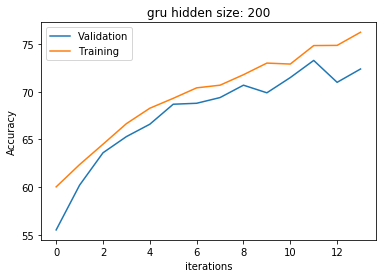

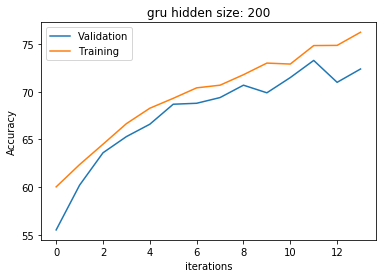

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline 
iters = [i for i in range(len(val_acc))]
plt.plot(iters, val_acc, iters, train_acc)
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('gru hidden size: 200')
plt.legend(['Validation', 'Training'])
plt.show()

In [37]:
def get_sample(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    worng_samples = []
    wrong_num = 0
    correct_samples = []
    correct_num = 0
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels, ind_backs in loader:
        data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, lengths_batch, ind_backs), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        sentences1 = data_batch[0]
        sentences1 = sentences1[ind_backs[0],...]
        sentences2 = data_batch[1]
        sentences2 = sentences2[ind_backs[1],...]
        
        #total += labels.size(0)
        for i in range(len(predicted)):
            if predicted[i] != labels[i] and wrong_num < 10:
                worng_samples.append((sentences1[i,...], sentences2[i,...], labels[i], predicted[i]))
                wrong_num += 1
            elif predicted[i] == labels[i] and correct_num < 10:
                correct_samples.append((sentences1[i,...], sentences2[i,...], labels[i], predicted[i]))
                correct_num += 1
            if wrong_num >= 10 and correct_num >= 10:
                break
                
        #correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (worng_samples, correct_samples)

In [38]:
test_samples = get_sample(val_loader, model)

In [39]:
worng_samples = []
correct_samples = []

for i in range(len(test_samples)):
    for ii in range(len(test_samples[i])):
        if i ==0:
            first_sen = []
            second_sen = []
            for iii in range(MAX_WORD_LENGTH):
                if test_samples[i][ii][0][iii] != 0:
                    first_sen.append(id2char[test_samples[i][ii][0][iii]])
                if test_samples[i][ii][1][iii] != 0:
                    second_sen.append(id2char[test_samples[i][ii][1][iii]])
            worng_samples.append((first_sen, second_sen, test_samples[i][ii][2], test_samples[i][ii][3]))
        elif i==1:
            first_sen = []
            second_sen = []
            for iii in range(MAX_WORD_LENGTH):
                if test_samples[i][ii][0][iii] != 0:
                    first_sen.append(id2char[test_samples[i][ii][0][iii]])
                if test_samples[i][ii][1][iii] != 0:
                    second_sen.append(id2char[test_samples[i][ii][1][iii]])
            correct_samples.append((first_sen, second_sen, test_samples[i][ii][2], test_samples[i][ii][3]))

In [40]:
worng_samples[8]

(['a', 'crowd', 'of', 'people', 'walk', 'on', 'a', 'pavement', 'at', 'night'],
 ['<unk>', 'be', 'the', 'even'],
 tensor(0),
 tensor([2]))

(['a', 'crowd', 'of', 'people', 'walk', 'on', 'a', 'pavement', 'at', 'night'],
 ['<unk>', 'be', 'the', 'even'],
 tensor(0),
 tensor([2]))

In [41]:
correct_samples[2]

(['a', 'family', 'sit', 'on', 'a', 'bench', 'near', 'a', 'beach'],
 ['a', 'family', 'be', 'eat', 'lunch', 'while', 'eat', 'on', 'a', 'bench'],
 tensor(2),
 tensor([2]))

(['a', 'family', 'sit', 'on', 'a', 'bench', 'near', 'a', 'beach'],
 ['a', 'family', 'be', 'eat', 'lunch', 'while', 'eat', 'on', 'a', 'bench'],
 tensor(2),
 tensor([2]))

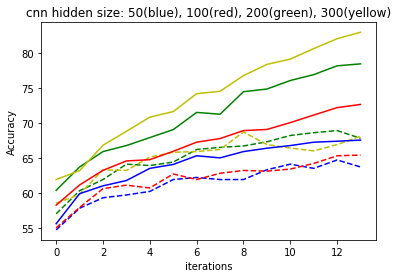

[57.0, 60.3, 61.9, 64.1, 63.9, 64.4, 66.2, 66.5, 66.7, 67.3, 68.2, 68.6, 68.9, 67.8]


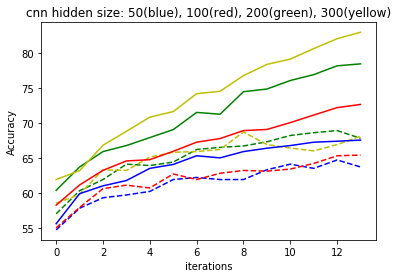

[57.0, 60.3, 61.9, 64.1, 63.9, 64.4, 66.2, 66.5, 66.7, 67.3, 68.2, 68.6, 68.9, 67.8]


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 

val_acc_50, train_acc_50 = pickle.load(open("./model/snli_acc_e7_h50_k3.p", "rb"))
val_acc_100, train_acc_100 = pickle.load(open("./model/snli_acc_e7_h100_k3.p", "rb"))
val_acc_200, train_acc_200 = pickle.load(open("./model/snli_acc_e7_h200_k3.p", "rb"))
val_acc_300, train_acc_300 = pickle.load(open("./model/snli_acc_e7_h300_k3.p", "rb"))
iters = [i for i in range(len(val_acc_50))]
plt.plot(iters, val_acc_50, 'b--', iters, val_acc_100, 'r--', iters, val_acc_200, 'g--', iters, val_acc_300, 'y--')
plt.plot(iters, train_acc_50, 'b', iters, train_acc_100, 'r', iters, train_acc_200, 'g', iters, train_acc_300, 'y')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('cnn hidden size: 50(blue), 100(red), 200(green), 300(yellow)')
#plt.legend(['Validation', 'Training'])
plt.show()
print(val_acc_200)

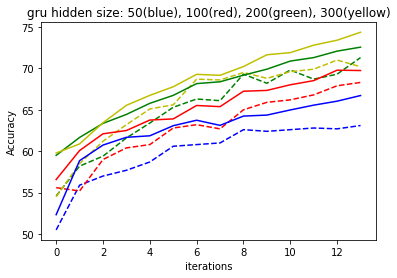

[54.6, 58.2, 59.4, 61.6, 63.4, 65.3, 66.3, 66.1, 69.3, 68.2, 69.8, 68.7, 69.3, 71.3]


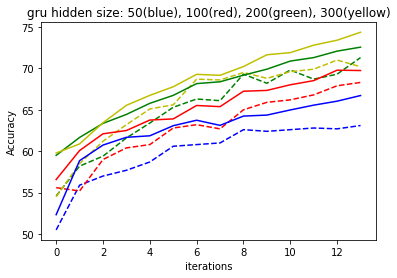

[54.6, 58.2, 59.4, 61.6, 63.4, 65.3, 66.3, 66.1, 69.3, 68.2, 69.8, 68.7, 69.3, 71.3]


In [43]:
val_acc_50, train_acc_50 = pickle.load(open("./model/snli_gru_acc_e7_h50.p", "rb"))
val_acc_100, train_acc_100 = pickle.load(open("./model/snli_gru_acc_e7_h100.p", "rb"))
val_acc_200, train_acc_200 = pickle.load(open("./model/snli_gru_acc_e7_h200.p", "rb"))
val_acc_300, train_acc_300 = pickle.load(open("./model/snli_gru_acc_e7_h300.p", "rb"))
iters = [i for i in range(len(val_acc_50))]
plt.plot(iters, val_acc_50, 'b--', iters, val_acc_100, 'r--', iters, val_acc_200, 'g--', iters, val_acc_300, 'y--')
plt.plot(iters, train_acc_50, 'b', iters, train_acc_100, 'r', iters, train_acc_200, 'g', iters, train_acc_300, 'y')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('gru hidden size: 50(blue), 100(red), 200(green), 300(yellow)')
#plt.legend(['Validation', 'Training'])
plt.show()
print(val_acc_200)

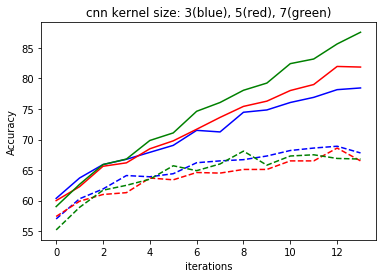

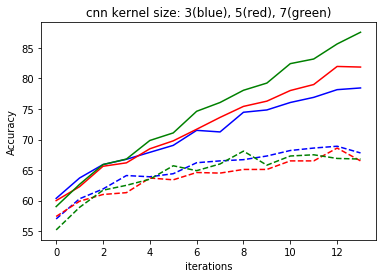

In [44]:
val_acc_3, train_acc_3 = pickle.load(open("./model/snli_acc_e7_h200_k3.p", "rb"))
val_acc_5, train_acc_5 = pickle.load(open("./model/snli_acc_e7_h200_k5.p", "rb"))
val_acc_7, train_acc_7 = pickle.load(open("./model/snli_acc_e7_h200_k7.p", "rb"))
iters = [i for i in range(len(val_acc_50))]
plt.plot(iters, val_acc_3, 'b--', iters, val_acc_5, 'r--', iters, val_acc_7, 'g--')
plt.plot(iters, train_acc_3, 'b', iters, train_acc_5, 'r', iters, train_acc_7, 'g')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('cnn kernel size: 3(blue), 5(red), 7(green)')
#plt.legend(['Validation', 'Training'])
plt.show()

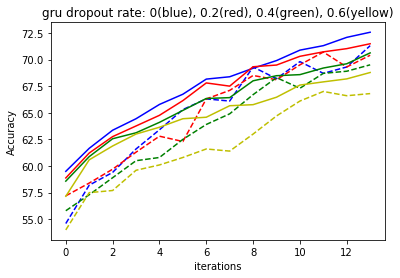

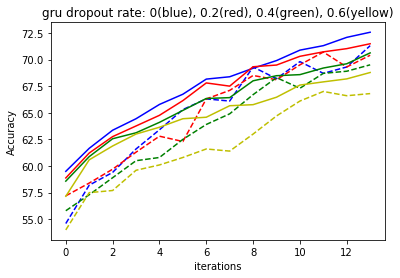

In [45]:
val_acc_50, train_acc_50 = pickle.load(open("./model/snli_gru_acc_e7_h200.p", "rb"))
val_acc_100, train_acc_100 = pickle.load(open("./model/snli_gru_acc_e7_h200_d0.2.p", "rb"))
val_acc_200, train_acc_200 = pickle.load(open("./model/snli_gru_acc_e7_h200_d0.4.p", "rb"))
val_acc_300, train_acc_300 = pickle.load(open("./model/snli_gru_acc_e7_h200_d0.6.p", "rb"))
iters = [i for i in range(len(val_acc_50))]
plt.plot(iters, val_acc_50, 'b--', iters, val_acc_100, 'r--', iters, val_acc_200, 'g--', iters, val_acc_300, 'y--')
plt.plot(iters, train_acc_50, 'b', iters, train_acc_100, 'r', iters, train_acc_200, 'g', iters, train_acc_300, 'y')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.title('gru dropout rate: 0(blue), 0.2(red), 0.4(green), 0.6(yellow)')
#plt.legend(['Validation', 'Training'])
plt.show()

In [22]:
# entailment=0, contradict=1, neural=2
def read_mnli_tsv(path):
    telephone_data = [] 
    travel_data = [] 
    fiction_data = [] 
    government_data = [] 
    slate_data = [] 
    with open(path) as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for row in reader:
            if row[2] == 'label':
                continue
            if row[3] == 'telephone': 
                if row[2] == 'entailment':
                    telephone_data.append((row[0],row[1], 0))
                elif row[2] == 'contradiction':
                    telephone_data.append((row[0],row[1], 1))
                else:
                    telephone_data.append((row[0],row[1], 2))
            if row[3] == 'travel': 
                if row[2] == 'entailment':
                    travel_data.append((row[0],row[1], 0))
                elif row[2] == 'contradiction':
                    travel_data.append((row[0],row[1], 1))
                else:
                    travel_data.append((row[0],row[1], 2))
            if row[3] == 'fiction': 
                if row[2] == 'entailment':
                    fiction_data.append((row[0],row[1], 0))
                elif row[2] == 'contradiction':
                    fiction_data.append((row[0],row[1], 1))
                else:
                    fiction_data.append((row[0],row[1], 2))
            if row[3] == 'government': 
                if row[2] == 'entailment':
                    government_data.append((row[0],row[1], 0))
                elif row[2] == 'contradiction':
                    government_data.append((row[0],row[1], 1))
                else:
                    government_data.append((row[0],row[1], 2))
            if row[3] == 'slate': 
                if row[2] == 'entailment':
                    slate_data.append((row[0],row[1], 0))
                elif row[2] == 'contradiction':
                    slate_data.append((row[0],row[1], 1))
                else:
                    slate_data.append((row[0],row[1], 2))
                    
    return (telephone_data, travel_data, fiction_data, government_data, slate_data)

In [24]:
telephone_data, travel_data, fiction_data, government_data, slate_data = read_mnli_tsv('./hw2_data/mnli_val.tsv')

In [25]:
telephone_data = covert_to_token(telephone_data)
travel_data = covert_to_token(travel_data)
fiction_data = covert_to_token(fiction_data)
government_data = covert_to_token(government_data)
slate_data = covert_to_token(slate_data)

In [26]:
telephone_data = process_data(telephone_data)
travel_data = process_data(travel_data)
fiction_data = process_data(fiction_data)
government_data = process_data(government_data)
slate_data = process_data(slate_data)

In [27]:
telephone_dataset = VocabDataset(telephone_data, char2id)
telephone_loader = torch.utils.data.DataLoader(dataset=telephone_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
travel_dataset = VocabDataset(travel_data, char2id)
travel_loader = torch.utils.data.DataLoader(dataset=travel_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
fiction_dataset = VocabDataset(fiction_data, char2id)
fiction_loader = torch.utils.data.DataLoader(dataset=fiction_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
government_dataset = VocabDataset(government_data, char2id)
government_loader = torch.utils.data.DataLoader(dataset=government_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
slate_dataset = VocabDataset(slate_data, char2id)
slate_loader = torch.utils.data.DataLoader(dataset=slate_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [31]:
print('telephone', test_model(telephone_loader, model))
print('travel', test_model(travel_loader, model))
print('fiction', test_model(fiction_loader, model))
print('government', test_model(government_loader, model))
print('slate', test_model(slate_loader, model))

telephone 48.159203980099505
telephone 48.159203980099505
travel 44.60285132382892
travel 44.60285132382892
fiction 51.256281407035175
fiction 51.256281407035175
government 48.818897637795274
government 48.818897637795274
slate 42.81437125748503
slate 42.81437125748503
